## This model works on the __Multiplier Ratio (_r_)__ prediction for the __Logan VT Rescaling__.

### Import

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
# import matplotlib
# matplotlib.use('Agg')
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
from scipy import stats
import itertools
from pprint import pprint

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
# from lazypredict.Supervised import LazyRegressor

from varname import nameof
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Necessary Functions

In [3]:
# Helper Function for metric reporting.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    # print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Average Error: {:0.4f} degrees.'.format(errors.mean()))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [5]:
def run_gbr_model(X, y, docstring=""):
    """
    Input: X and Y. docstring for the name of plot saving. Usually date.
    Output: The Sk-Learn Model for analysis, and the MAE errors as metrics.
    TODO: generate R2 values?
    """
    y_true_base, y_pred_base = list(), list()
    mae_errs_base = list()
    cv = LeaveOneOut()
    y_true, y_pred = list(), list()
    mae_errs = list()

    fig = plt.figure()
    # set palette
    palette = itertools.cycle(sns.color_palette())

    for train_index, test_index in cv.split(X):
        #         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        gbr = GradientBoostingRegressor(
            random_state=42,
            min_samples_leaf=2,
            n_estimators=400,
            max_features=20,
            max_leaf_nodes=4,
            min_samples_split=2,
            learning_rate=0.05,
        )
        model_gbr = MultiOutputRegressor(gbr)
        # Look at parameters used by our current forest
    #     print('Parameters currently in use:\n')
    #     pprint(model_gbr.estimator.get_params())
        # Base model evaluation: Fit the regressor with x and y data
        # use this if age, weight, and auc are scaled by a constant
        model_gbr.fit(X_train.values, y_train.values)
        base_model_accuracy = evaluate(
            model_gbr, X_test.to_numpy(), y_test.to_numpy())

        yhat = model_gbr.predict(X_test)

        # store
        y_true_base.append(y_test.to_numpy())
        y_pred_base.append(yhat)

        print('MAE:', mean_absolute_error(y_test, yhat))
        mae_errs_base.append(mean_absolute_error(y_test, yhat))

        c = next(palette)
        # sns.regplot(x=y_test, y=yhat, scatter_kws={"color": "red"}, line_kws={"color": "black"})
    #     sns.set(rc={"figure.figsize":(7, 7)})
        sns.regplot(x=yhat.reshape(-1),
                    y=np.array(y_test).reshape(-1), color=c, ci=None)
        fig.legend(df['ATLaS_ID'].unique())
        plt.title('Multi output GBR - individual regression lines')
        plt.ylabel('Observed Logan VT (from AIF)')
        plt.xlabel('Predicted Logan VT')
        plt.axis('equal')
        plt.savefig(f"GBR-Lineplot{docstring}.png")

    fig = plt.figure()
    sns.set(rc={"figure.figsize": (7, 7)})
    sns.regplot(x=np.vstack(y_pred_base).flatten(),
                y=np.vstack(y_true_base).flatten(), scatter=False)
    sns.scatterplot(x=np.vstack(y_pred_base).flatten(), y=np.vstack(
        y_true_base).flatten(), hue=ATLaS_ID, palette="bright", legend="full")
    slope_p, intercept_p, r_value_p, p_value_p, std_err_p = stats.linregress(
        np.vstack(y_true_base).flatten(), np.vstack(y_pred_base).flatten())
    plt.title('Multi output GBR - common regression lines')
    plt.ylabel('Observed Logan VT (from AIF)')
    plt.xlabel('Predicted Logan VT')
    plt.axis('equal')
    plt.savefig(f"GBR-Scatter_{docstring}.png")

    print('Pearson correlation R and p-val are: ',
          r_value_p.round(5), ',', p_value_p)

    return model_gbr, mae_errs_base

### Read The Data

Notice: If the data we use have been changed, refer to `New Regression.ipynb`

In [55]:
# The Logan VT from PBIF-generated pAIFs. 
X_1 = pd.read_csv("../AUC-PBIF-X.csv", index_col=0)

In [23]:
# The Logan VT from Observed AIFs. 
Y = pd.read_csv("../ground_truth.csv", index_col=0)

In [105]:
# The dataset to make the scatter and results plots.
df_plot_long = pd.read_csv("Table_For_Plots.csv", index_col=0)

### Compute the "slope" r

In [60]:
X = X_1.iloc[:,6:].values

In [33]:
Y = Y.values

In [45]:
r = np.zeros(32)
for i in range(32):
    xi = X[i]
    yi = Y[i]
    r[i] = np.dot(xi, yi)/np.dot(xi, xi)  

The numpy array `r` contains the 32 target values we are trying to predict.

### Modeling

In [72]:
selected_features = ['Age', 'Sex', 'NET dose (mCi)', 'Weight (Kgs)', 'Genotype', "mean", "std"]
X = X_1.iloc[:,6:]
X_1.loc[:, "mean"] = (X.T.describe().T)["mean"]
X_1.loc[:, "std"] = (X.T.describe().T)["std"]

In [74]:
X_1[selected_features].head()

,Age,Sex,NET dose (mCi),Weight (Kgs),Genotype,mean,std
0,6.8,1,16.09,8.164663,2,3.402308,0.684709
1,5.9,1,14.36,8.164663,2,3.669662,0.562657
2,6.3,1,12.86,8.164663,1,2.977987,0.434179
3,7.1,1,13.37,6.577089,2,5.055895,0.821507
4,6.2,1,13.50,5.624545,2,5.566739,0.870398


In [80]:
# 
selected_features = ['Age', 'NET dose (mCi)', 'Weight (Kgs)', "mean", "std"]

model_slope = GradientBoostingRegressor(random_state=42, 
                        min_samples_leaf=2, 
                        n_estimators=400, 
                        max_features=3, 
                        max_leaf_nodes=2,
                        min_samples_split=2,
                        learning_rate=0.05,
                               )

model_slope.fit(X_1[selected_features].values, r)  
base_model_accuracy = evaluate(model_slope, X_1[selected_features].values, r)

yhat_slope = model_slope.predict(X_1[selected_features].values)
print(r2_score(r, yhat_slope))

Model Performance
Average Error: 0.0621 degrees.
Accuracy = 94.01%.
0.9510082105572092


### Calculation

In [106]:
df_plot_long.head()

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488
1,1002,ctx-lh-bankssts-PBIF,4.198218,ctx-lh-bankssts-AIF,4.177566,3.544963
2,1003,ctx-lh-bankssts-PBIF,2.927057,ctx-lh-bankssts-AIF,6.798339,2.808292
3,1004,ctx-lh-bankssts-PBIF,4.971960,ctx-lh-bankssts-AIF,4.504249,5.226326
4,1005,ctx-lh-bankssts-PBIF,12.967565,ctx-lh-bankssts-AIF,6.187557,5.622179


In [96]:
# Appending the computed results using Y = r*X
subjs = df_plot_long.ATLaS_ID.unique()

for i, subj in enumerate(subjs):
    df_by_subj = df_plot_long.loc[df_plot_long.ATLaS_ID == subj]
    slope_hat = yhat_slope[i]
    df_by_subj.loc[:, "VT_PRED_SLOPE"] = df_by_subj["VT_PBIF_NEW"] * slope_hat
    if i == 0:
        df_plot_new_predictions = df_by_subj.copy()
    else:
        df_plot_new_predictions = pd.concat((df_plot_new_predictions, df_by_subj.copy()), axis=0)

In [107]:
df_plot_new_predictions.head()

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW,VT_PRED_SLOPE
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488,3.094713
16,1001,ctx-lh-bankssts-PBIF,3.251344,ctx-lh-bankssts-AIF,2.927193,3.354556,2.857927
32,1001,ctx-lh-caudalanteriorcingulate-PBIF,1.764931,ctx-lh-caudalanteriorcingulate-AIF,1.873116,1.415929,1.206306
48,1001,ctx-lh-caudalanteriorcingulate-PBIF,2.663417,ctx-lh-caudalanteriorcingulate-AIF,2.312698,2.799238,2.384822
64,1001,ctx-lh-caudalmiddlefrontal-PBIF,3.675814,ctx-lh-caudalmiddlefrontal-AIF,3.026488,3.816396,3.251394


### Ploting

In [113]:
df_plot_long

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488
1,1002,ctx-lh-bankssts-PBIF,4.198218,ctx-lh-bankssts-AIF,4.177566,3.544963
2,1003,ctx-lh-bankssts-PBIF,2.927057,ctx-lh-bankssts-AIF,6.798339,2.808292
3,1004,ctx-lh-bankssts-PBIF,4.971960,ctx-lh-bankssts-AIF,4.504249,5.226326
4,1005,ctx-lh-bankssts-PBIF,12.967565,ctx-lh-bankssts-AIF,6.187557,5.622179
...,...,...,...,...,...,...
1371,FR,Left-VentralDC-PBIF,1.465100,Left-VentralDC-AIF,2.358200,2.080599
1372,JD,Left-VentralDC-PBIF,4.121210,Left-VentralDC-AIF,4.128987,4.530286
1373,KT,Left-VentralDC-PBIF,2.258635,Left-VentralDC-AIF,1.549575,2.376695
1374,MM,Left-VentralDC-PBIF,6.226527,Left-VentralDC-AIF,6.120247,5.945923


In [118]:
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

('Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

In [ ]:
deep , muted , pastel , bright , dark , and colorblind 

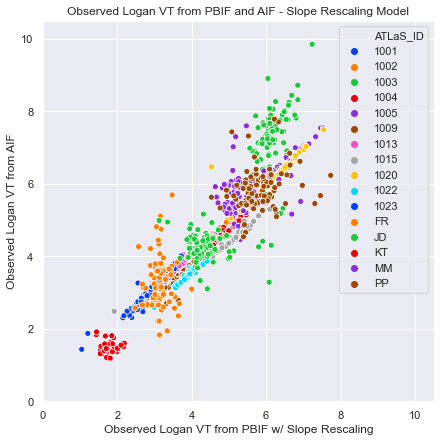

In [151]:
# The Y = r*X + 0
# sns.palettes("husl", 16)
sns.color_palette("hls", 16)
sns.set(rc={"figure.figsize": (7, 7)})
sns.scatterplot(data=df_plot_new_predictions, x='VT_PRED_SLOPE',
                y='VT_AIF', hue="ATLaS_ID", palette="bright")
sns.color_palette("hls", 16)
plt.title('Observed Logan VT from PBIF and AIF - Slope Rescaling Model')
plt.xlabel('Observed Logan VT from PBIF w/ Slope Rescaling')
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.ylabel('Observed Logan VT from AIF')
# plt.show()
plt.savefig("SlopeModel_20230111_husl.png", dpi=600)

In [104]:
mean_absolute_error(df_plot_new_predictions.VT_AIF, df_plot_new_predictions.VT_PRED_SLOPE)

0.34601473784897707

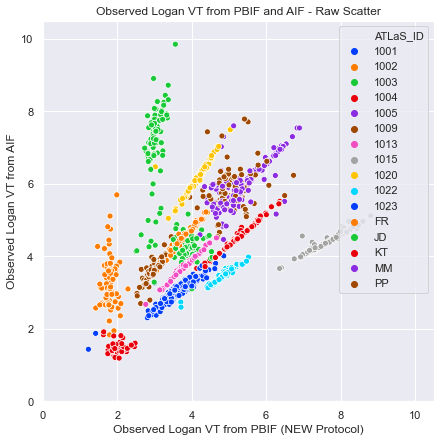

In [110]:
sns.set(rc={"figure.figsize":(7, 7)})

# plot original data --- NEW
sns.scatterplot(data=df_plot_long, x='VT_PBIF_NEW', y='VT_AIF', hue="ATLaS_ID", palette="bright")
plt.title('Observed Logan VT from PBIF and AIF - Raw Scatter')
plt.xlabel('Observed Logan VT from PBIF (NEW Protocol)')
plt.xlim(0, 10.5)
plt.ylim(0, 10.5)
plt.ylabel('Observed Logan VT from AIF')
# plt.show()
plt.savefig("Original_scatter_plot_20131011.png", dpi=600)

In [148]:
ulk = {}
IDs = df_plot_new_predictions.ATLaS_ID.unique()
for sid in IDs:
    tmp_df = df_plot_new_predictions.loc[df_plot_new_predictions.ATLaS_ID==sid]
    ulk[sid] = r2_score(tmp_df.VT_AIF, tmp_df.VT_PRED_SLOPE)
    

In [150]:
df_plot_new_predictions

,ATLaS_ID,regions_PBIF,VT_PBIF,regions_AIF,VT_AIF,VT_PBIF_NEW,VT_PRED_SLOPE
0,1001,ctx-lh-bankssts-PBIF,3.618592,ctx-lh-bankssts-AIF,3.125203,3.632488,3.094713
16,1001,ctx-lh-bankssts-PBIF,3.251344,ctx-lh-bankssts-AIF,2.927193,3.354556,2.857927
32,1001,ctx-lh-caudalanteriorcingulate-PBIF,1.764931,ctx-lh-caudalanteriorcingulate-AIF,1.873116,1.415929,1.206306
48,1001,ctx-lh-caudalanteriorcingulate-PBIF,2.663417,ctx-lh-caudalanteriorcingulate-AIF,2.312698,2.799238,2.384822
64,1001,ctx-lh-caudalmiddlefrontal-PBIF,3.675814,ctx-lh-caudalmiddlefrontal-AIF,3.026488,3.816396,3.251394
...,...,...,...,...,...,...,...
1311,PP,Left-Amygdala-PBIF,3.830682,Left-Amygdala-AIF,6.278149,5.581217,6.408240
1327,PP,Left-Accumbens-area-PBIF,4.258944,Left-Accumbens-area-AIF,6.845310,5.776103,6.632005
1343,PP,Left-Accumbens-area-PBIF,3.937894,Left-Accumbens-area-AIF,6.252835,5.340895,6.132308
1359,PP,Left-VentralDC-PBIF,4.091883,Left-VentralDC-AIF,6.621300,6.017672,6.909370


In [149]:
ulk

{'1001': 0.8178107985143418,
 '1002': 0.9485094611423879,
 '1003': -0.48971944726208516,
 '1004': 0.6996961544128686,
 '1005': 0.9646984483921023,
 '1009': 0.5081679776720256,
 '1013': 0.9115115207298585,
 '1015': -0.15632175369387258,
 '1020': 0.7606979696731138,
 '1022': -3.3267229236984495,
 '1023': 0.6913727963915005,
 'FR': -0.17118618332936308,
 'JD': -1.1885748001536451,
 'KT': -7.959913526933791,
 'MM': -1.338870648152286,
 'PP': -0.5323650378516933}

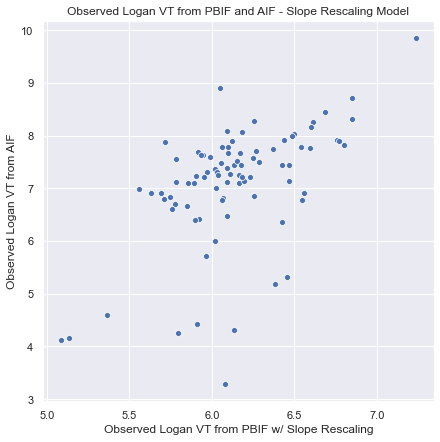

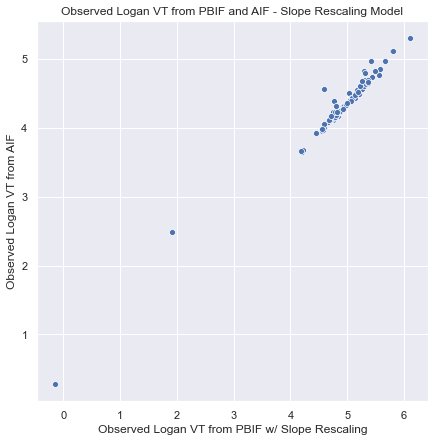

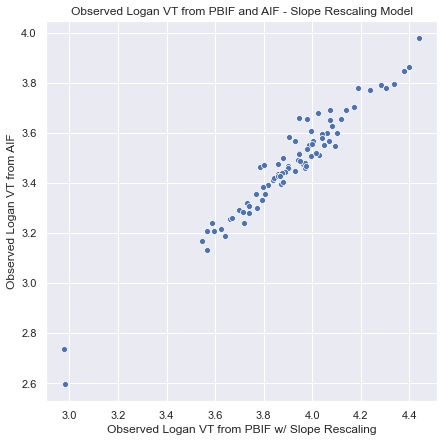

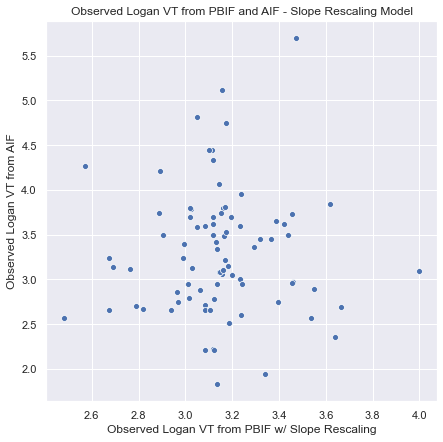

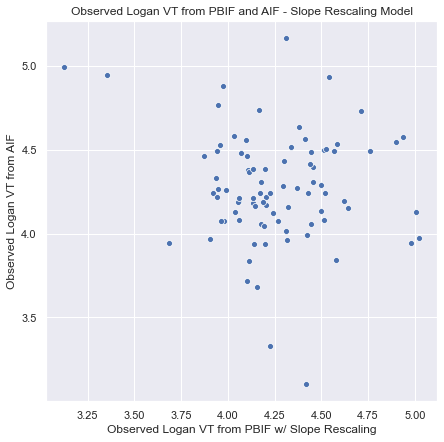

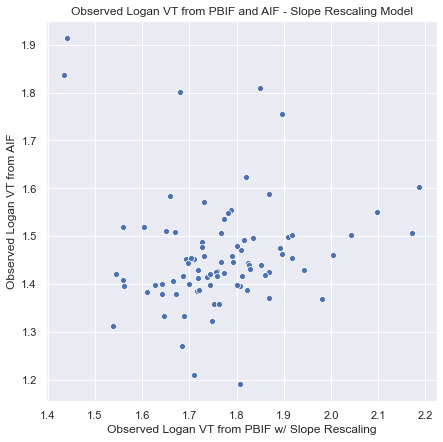

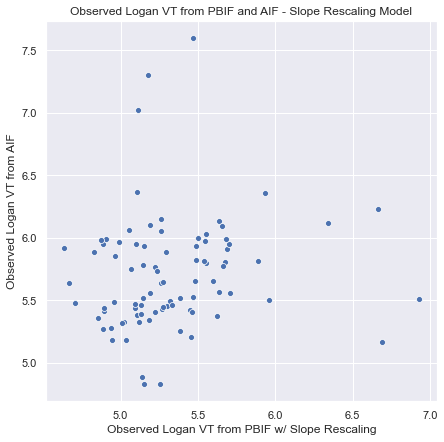

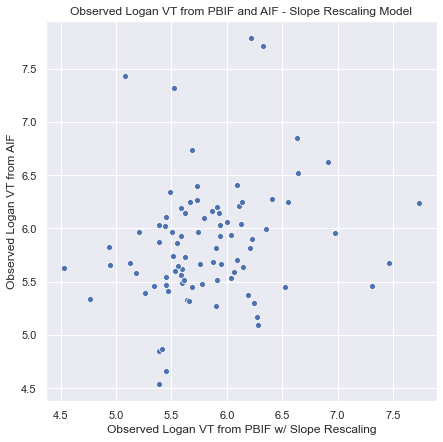

In [154]:
# Report R value or individual LinR (slope==1, intercept==0)
# The Y = r*X + 0
for outlier in ['1003', '1015', '1022', 'FR', 'JD', "KT", 'MM', 'PP']:
    sns.color_palette("hls", 16)
    sns.set(rc={"figure.figsize": (7, 7)})
    sns.scatterplot(data=df_plot_new_predictions.loc[df_plot_new_predictions.ATLaS_ID == outlier], x='VT_PRED_SLOPE',
                    y='VT_AIF')
    sns.color_palette("hls", 16)
    plt.title('Observed Logan VT from PBIF and AIF - Slope Rescaling Model')
    plt.xlabel('Observed Logan VT from PBIF w/ Slope Rescaling')
    # plt.xlim(0, 10.5)
    # plt.ylim(0, 10.5)
    plt.ylabel('Observed Logan VT from AIF')
    plt.show()
    # plt.savefig("SlopeModel_20230111_husl.png", dpi=600)

In [155]:
r2_score(df_plot_new_predictions.VT_AIF, df_plot_new_predictions.VT_PRED_SLOPE)

0.8764414421519633

In [ ]:
# 